# CASE STUDY 4

Amber Whelpley, Festus Asare Yeboah, KJ Price

## Time Series Forecasting - Evaluating p, d, q values  for ARIMA Models

Data that is distributed over time can be considered as a time series data. Time series forecasting is the process of using statistical methods to predict future values based on previous values.

One method used to forecast future values is the ARIMA model. ARIMA stands for Auto Regressive Integrated Moving Average. ARIMA prediction is based on the asuumption that a particalar time series data is stationary and that over a period of time, current values are related or correlated  with thier immediate previous n values. 

This model takes in 3 parameters; p, d and q. The AR part of ARIMA refers to the  the way  the model utilizes past values in its regression to predict values. This part is referred to as p  and it is used to specify the number of lags used in the model fitting. For instance chosing a p value of 2  is equivalent to ARIMA(2,0,0).

The d parameter covers the Integrated part of the model. It represents the degree of differencing during model fitting .Differencing is simply subtracting current and previous values d times. Because the ARIMA model requires the stationary condition is met, differencing is  used when this condition is not met.

The last paratmeter q represents the MA component. Its value represents the error of the model as a combination of previous error terms et. The order q determines the number of terms to included in the model

In this case study, we aim to estimate the best combination of p, d and q values to  predict future facebook(FB) stocks. We employ two methods to estimate these values. We start by using  auto correlation and partial auto correlation plots ang go ahead to apply a brute force method called Grid Search.

Grid search is a hyper paramter tuning algorithm that fits a model on a combinations of model parameters while keeping the best model evuluation score.




In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import quandl
import datetime
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
from pandas_datareader import data as web
import pandas as pd

from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
pd.core.common.is_list_like = pd.api.types.is_list_like
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 2, 1)
price = web.DataReader('FB', 'iex', start, end)['close']
price.index = pd.to_datetime(price.index)

date
2014-03-07    69.8000
2014-03-10    72.0300
2014-03-11    70.1000
2014-03-12    70.8799
2014-03-13    68.8300
Name: close, dtype: float64


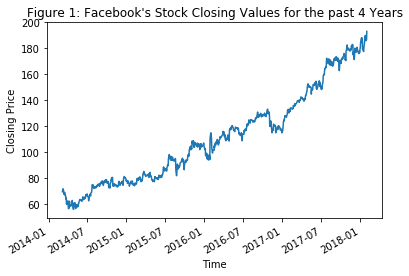

In [3]:
print(price.head())
fig = plt.figure()

price.plot()
plt.title("Figure 1: Facebook's Stock Closing Values for the past 4 Years")
plt.xlabel("Time")
plt.ylabel('Closing Price')
plt.show()

Figure 1 shows the plotted time series for Facebook's stock closing pricesbetween 1/1/2014 and 2/1/2018.

In [4]:

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


The test_stationarity function tests for stationarity based upon the Dicky-Fuller Test. If the p-value is above 0.05, the data is not stationary, meaning there are significant trends in the time series.  A p-value under 0.05 suggests that the data is stationary.

Figure 2 shows the test for stationarity while plotting rolling mean and rolling standard deviation across the time series. The p-value is above 0.05, suggesting that the data is not stationary.

Figure 2: Rolling Mean and Standard Deviation


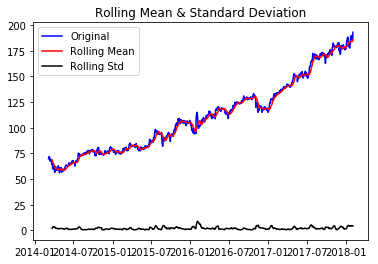

Results of Dickey-Fuller Test:
Test Statistic                   1.092559
p-value                          0.995153
#Lags Used                       8.000000
Number of Observations Used    976.000000
Critical Value (1%)             -3.437068
Critical Value (5%)             -2.864506
Critical Value (10%)            -2.568349
dtype: float64


In [5]:
print("Figure 2: Rolling Mean and Standard Deviation")
test_stationarity(price)

In Figure 3 we use a shift in price difference to test for stationarity, using a test statistic of -32.85 which provides a p-value of 1.115e-24, well below the threshold of 0.05. This allows for ARIMA analysis.

Figure 3: Rolling Mean and Standard Deviation after a shift in price difference


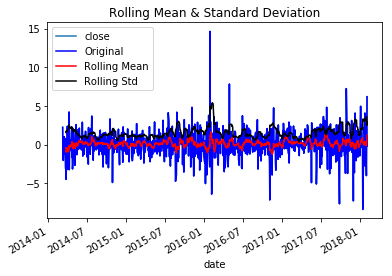

Results of Dickey-Fuller Test:
Test Statistic                -1.319684e+01
p-value                        1.114907e-24
#Lags Used                     7.000000e+00
Number of Observations Used    9.760000e+02
Critical Value (1%)           -3.437068e+00
Critical Value (5%)           -2.864506e+00
Critical Value (10%)          -2.568349e+00
dtype: float64


In [6]:
print("Figure 3: Rolling Mean and Standard Deviation after a shift in price difference")
diff=price-price.shift()
diff.dropna(inplace=True)
diff.plot()
test_stationarity(diff)

To find the p and q values for the ARIMA model, the autocorrelation function and partial autocorrelation function, ACF and PACF, are used. In Figure 4, it can be seen that the ACF plot converges to 0.0 at the lag value of 1, showing us that q = 1. Similarly, in Figure 5 the PACF plot converges to 0.0 at the lag value of 1 so p = 1. Since the original data had to be shifted to pass the Dicky-Fuller Test, the differencing value of d = 0. This gives an ARIMA model of (1, 0, 1).

Text(0.5, 1.0, 'Figure 4: Autocorrelation Function')

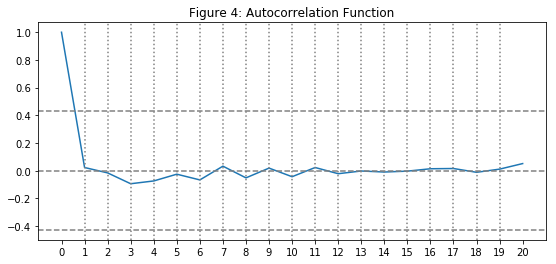

In [7]:
acf_air_plot = acf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Figure 4: Autocorrelation Function')

Text(0.5, 1.0, 'Figure 5: Partial Autocorrelation Function')

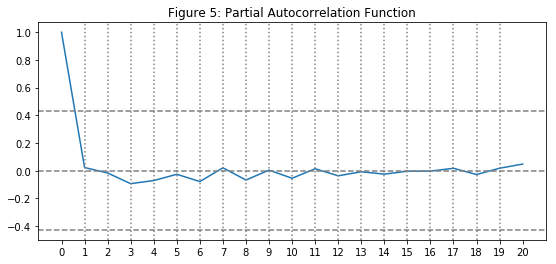

In [8]:
pacf_air_plot = pacf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Figure 5: Partial Autocorrelation Function')

The 1,0,1 ARIMA model statistics below shows that the first-order AR of -0.9569 is significant, with a p-value of under 0.0001. The same is true of the first-order MA of 0.979, which also has a p-value of under 0.0001.

The residual kernel density graph, shown in Figure 6, has one peak at 0.010120 showing that the model is a good fit.

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  984
Model:                     ARMA(1, 1)   Log Likelihood               -1912.883
Method:                       css-mle   S.D. of innovations              1.690
Date:                Thu, 07 Mar 2019   AIC                           3833.766
Time:                        15:13:51   BIC                           3853.333
Sample:                             0   HQIC                          3841.209
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1255      0.054      2.303      0.022       0.019       0.232
ar.L1.close    -0.9569      0.023    -41.282      0.000      -1.002      -0.911
ma.L1.close     0.9790      0.016     60.509    

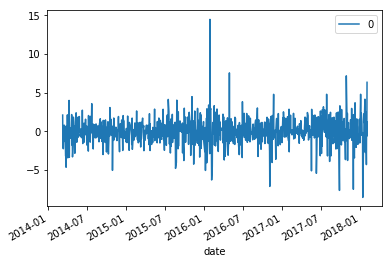

Figure 6: Kernel Density Estimate for the (1,0,1) ARIMA model


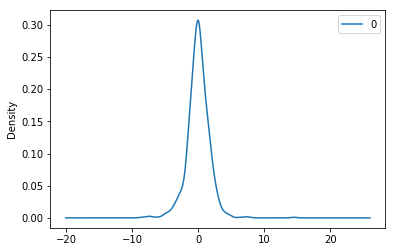

                0
count  984.000000
mean    -0.000018
std      1.691412
min     -8.546848
25%     -0.818388
50%      0.010120
75%      0.919708
max     14.476395


In [9]:
model = ARIMA(diff, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
print("Figure 5: Residuals for the (1,0,1) ARIMA model")
plt.show()
residuals.plot(kind='kde')
print("Figure 6: Kernel Density Estimate for the (1,0,1) ARIMA model")
plt.show()
print(residuals.describe())

Figure 7 shows the ARIMA predictions overlayed on the actual stock price values. 

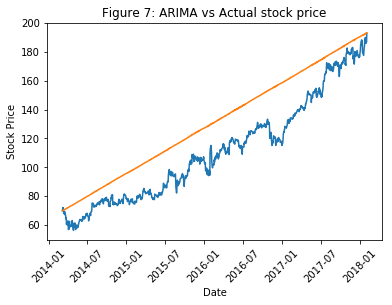

In [10]:
predictions_ARIMA_diff_cumsum = model_fit.fittedvalues.cumsum()
predictions_ARIMA = pd.Series(price.ix[0], index=price.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)

plt.plot(price);
plt.plot(predictions_ARIMA);
plt.title('Figure 7: ARIMA vs Actual stock price'% np.sqrt(sum((predictions_ARIMA-price)**2)/len(price)));
plt.xlabel('Date')
plt.xticks(rotation='45')
plt.ylabel('Stock Price')
plt.show();

A grid search is used to search through permutations of all possible p,d, and q values to determine the best fit based on the smalles root sum square value.

53.166562662001404


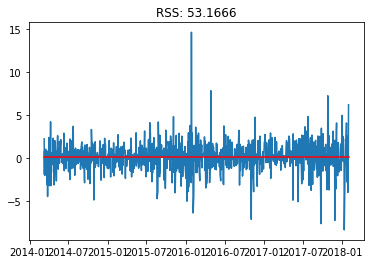

0 0 0
53.151894375140934


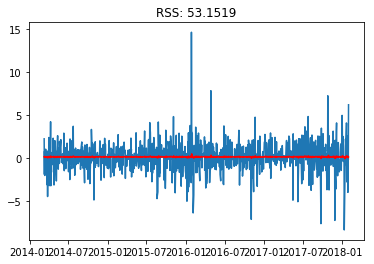

0 0 1
53.14746463601465


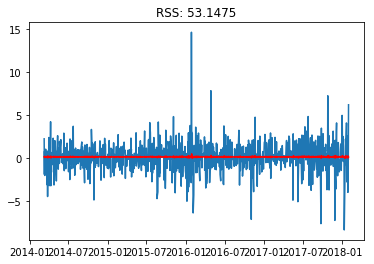

0 0 2


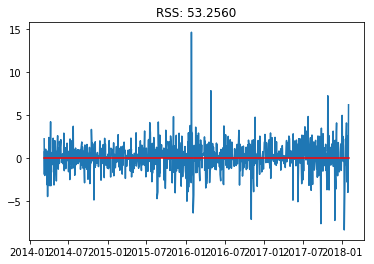

0 1 0


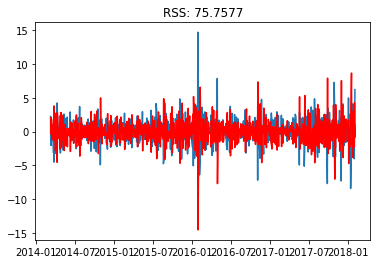

0 1 1


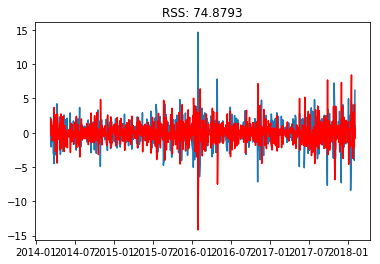

0 1 2


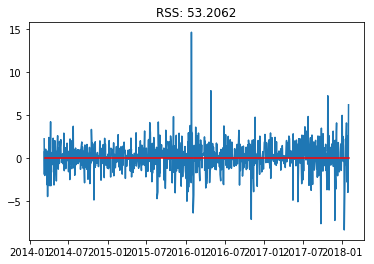

0 2 0


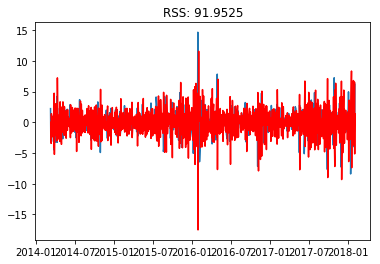

0 2 1


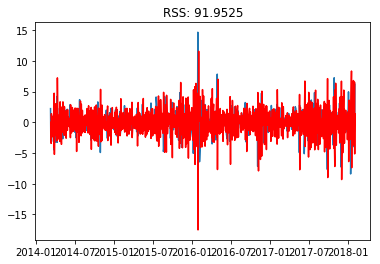

0 2 2


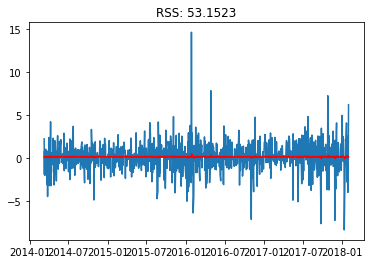

1 0 0
53.030565344469196


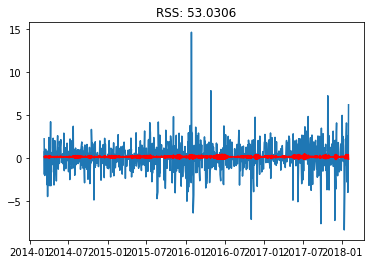

1 0 1


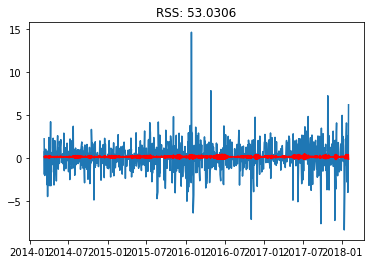

1 0 2


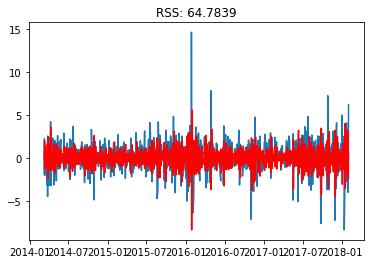

1 1 0


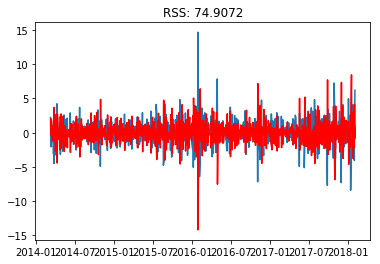

1 1 1


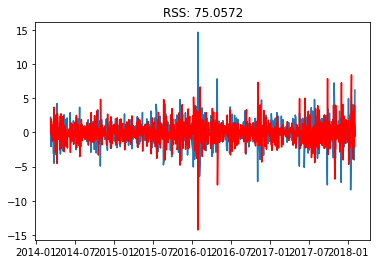

1 1 2


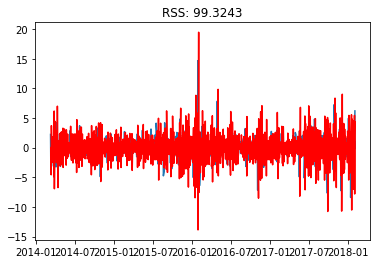

1 2 0


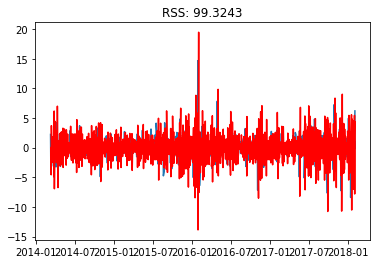

1 2 1


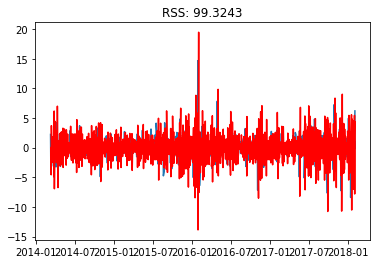

1 2 2


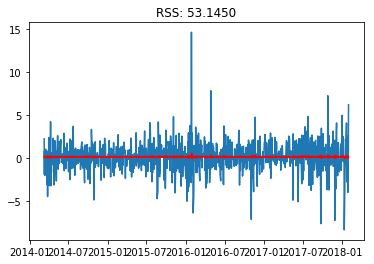

2 0 0
52.714486455145334


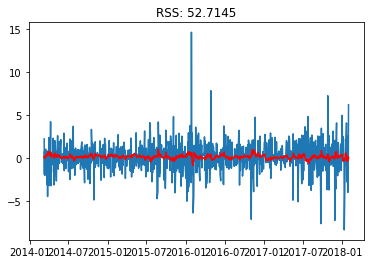

2 0 1


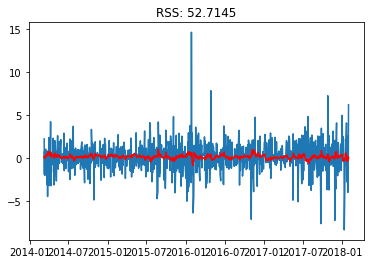

2 0 2


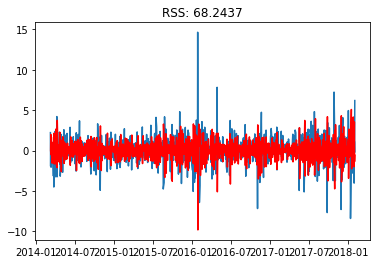

2 1 0


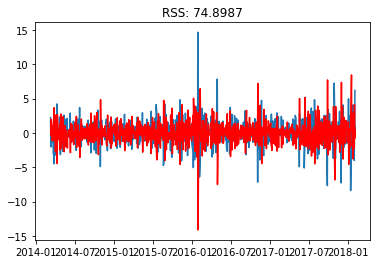

2 1 1


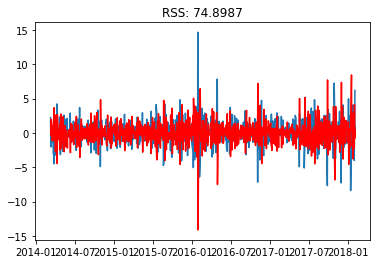

2 1 2


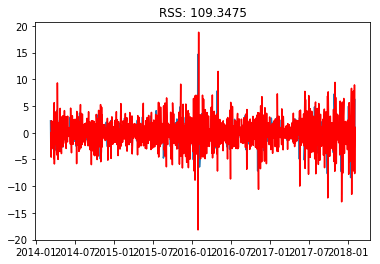

2 2 0


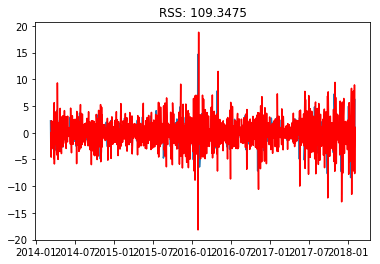

2 2 1


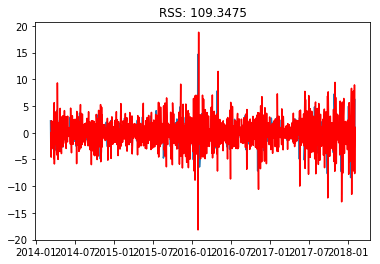

2 2 2


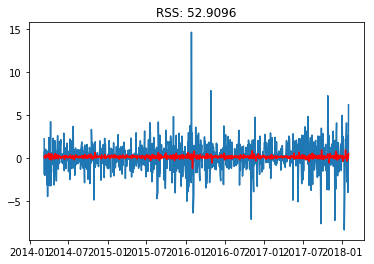

3 0 0
52.60781593577637


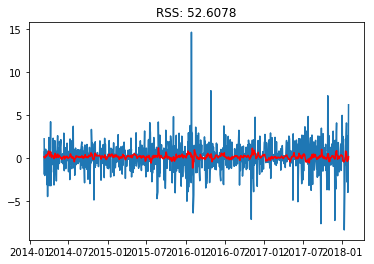

3 0 1
52.605579375201216


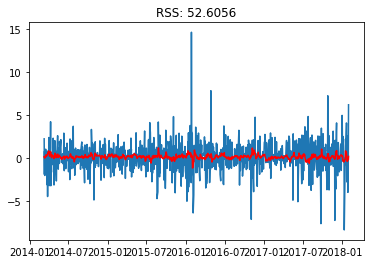

3 0 2


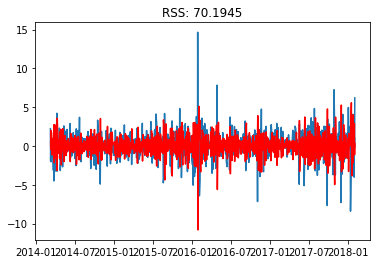

3 1 0


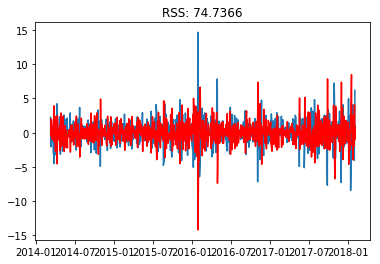

3 1 1


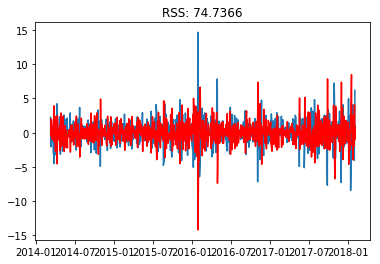

3 1 2


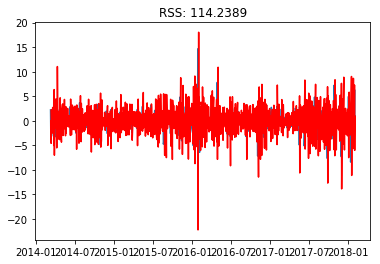

3 2 0


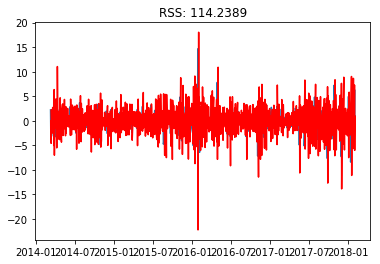

3 2 1


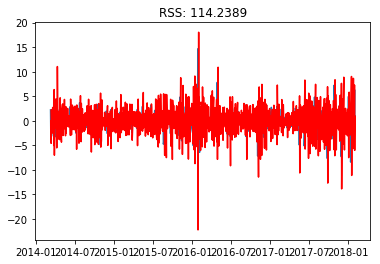

3 2 2


In [11]:
results = []
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            results.append({'q':q, 'p':p, 'd':d, 'loss':loss})
            plt.show()
            print(p,d,q)
results=pd.DataFrame(results).sort_values('loss').reset_index()

In [12]:
display(results[['p','d','q','loss']].iloc[:10])

,p,d,q,loss
0,3,0,2,52.605579
1,3,0,1,52.607816
2,2,0,2,52.714486
3,2,0,1,52.714486
4,3,0,0,52.909596
5,1,0,2,53.030565
6,1,0,1,53.030565
7,2,0,0,53.144993
8,0,0,2,53.147465
9,0,0,1,53.151894


The results of our grid search shows that the manual choices of p=1, d=0, and q=1 are down at 7th place. The actual best choices are (3, 0, 2) with gives the best loss of 52.605579.

Using the best parameters selected by the grid search, we examine the summary statistics again. The 3,0,2 ARIMA model statistics show that neither the second-order AR of 0.0616 nor the second-order MA of -0.6968 are significant, as their p-values are 0.844 and 0.762, respectively. This model is not optimal as it also requires imaginary numbers to compensate for the extra values, unlike the 1,0,1 model.

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  984
Model:                     ARMA(3, 2)   Log Likelihood               -1904.971
Method:                       css-mle   S.D. of innovations              1.677
Date:                Thu, 07 Mar 2019   AIC                           3823.942
Time:                        15:14:04   BIC                           3858.184
Sample:                             0   HQIC                          3836.966
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1241      0.035      3.519      0.000       0.055       0.193
ar.L1.close     0.7032      0.349      2.016      0.044       0.019       1.387
ar.L2.close     0.0616      0.314      0.197    

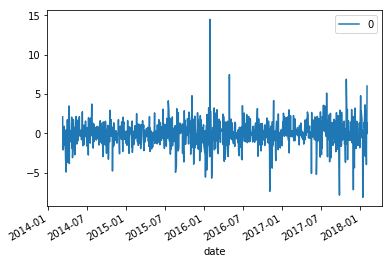

Figure 8: Kernel Density Estimate for the (3,0,2) ARIMA model


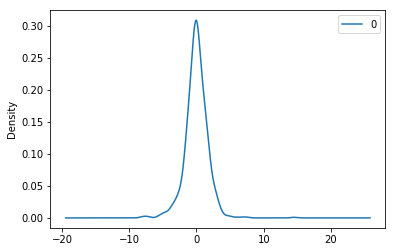

                0
count  984.000000
mean    -0.001452
std      1.677857
min     -8.134139
25%     -0.838166
50%     -0.007697
75%      0.896148
max     14.489234


In [13]:
model = ARIMA(diff, order=(3,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
print("Figure 5: Residuals for the (3,0,2) ARIMA model")
plt.show()
residuals.plot(kind='kde')
print("Figure 8: Kernel Density Estimate for the (3,0,2) ARIMA model")
plt.show()
print(residuals.describe())

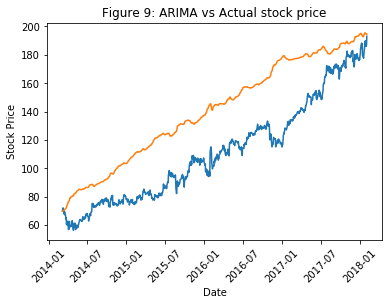

In [14]:
predictions_ARIMA_diff_cumsum = model_fit.fittedvalues.cumsum()
predictions_ARIMA = pd.Series(price.ix[0], index=price.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)

plt.plot(price);
plt.plot(predictions_ARIMA);
plt.title('Figure 9: ARIMA vs Actual stock price'% np.sqrt(sum((predictions_ARIMA-price)**2)/len(price)));
plt.xlabel('Date')
plt.xticks(rotation='45')
plt.ylabel('Stock Price')
plt.show();

The plot of the 3,0,2 ARIMA against the actual stock price seen in Figure 9 shows that this ARIMA is more variable than the 1,0,1 model when compared to the actual stock prices.